# Construction de fonctions permettant de séparer les phases de possessions

## Réflexions au préalable

Objectif 1 : Construire une base de données de la position de ballon (investiguer à partir des events)
    - On filtre les évents afin de récupérer l'information permettant de juger qui a le ballon (Time, Joueur, Equipe)
    - On récupère les positions du joueur possédant le ballon (Time, Joueur, Equipe, PosX, PosY)
    - On reconstruit la position de ballon en faisant des interpolations linéaires : le ballon suit une trajectoire rectiligne uniforme (Time, Joueur, Equipe, PosX, PosY)

Objectif 2 : Construire une BDD de phase de possession
    - Normalement easy à partir de l'objectif 1 

In [2]:
from fonctions_perso import sql_request
import matplotlib.pyplot as plt
from matplotlib import ticker
import numpy as np
import pandas as pd
import pickle

slt gro


## Objectif 1 : BDD de positions du ballon

In [3]:
print(sql_request("SELECT * FROM events").columns)
match_id = 'Match_001'
period_id = '1'
match_1_1 = sql_request("SELECT DISTINCT event_id, match_id, name_id, team_id, MIN, SEC, period_id FROM events WHERE match_id LIKE '%s' AND period_id LIKE '%s' ORDER BY event_id ASC" % (match_id, period_id))
match_1_1 = match_1_1.rename(columns = {"MIN":"minu",
                                         "SEC":"sec",
                                         "Name (Event Types)":"type",
                                         "Outcome":"outcome",
                                         "X Coordinates":"x",
                                         "Y Coordinates":"y",
                                         "Qualifier Type":"qualifier_type",
                                         "Description":"description",
                                         "Qualifier Value":"qualifier_value"})

Index(['period_id', 'MIN', 'SEC', 'Name (Event Types)', 'Outcome',
       'X Coordinates', 'Y Coordinates', 'Qualifier Type', 'Description',
       'Qualifier Value', 'date_id', 'match_id', 'name_id', 'team_id',
       'event_id'],
      dtype='object')


In [79]:
match_1_1.shape

(3736, 15)

In [4]:
def get_position(match_id, period_id, name_id, minute, sec):
    time_sec = minute*60 + sec + 0.0
    result = sql_request("SELECT * FROM tracking WHERE match_id LIKE '%s' AND ht LIKE '%s' AND name_id LIKE '%s' AND time_sec = %s" % (match_id, period_id, name_id, str(time_sec)))
    return result.iloc[0]

In [5]:
get_position(match_1_1.match_id[0], match_1_1.period_id[0], match_1_1.name_id[0], match_1_1.minu[0], match_1_1.sec[0])

time_sec           1813
ht                    1
posx               -269
posy              -1061
name_id     Player_0063
team_id         Team_02
date_id        Date_001
match_id      Match_001
Name: 0, dtype: object

In [6]:
test = match_1_1.apply(lambda df: get_position(df.match_id, df.period_id, df.name_id, df.minu, df.sec), axis=1)

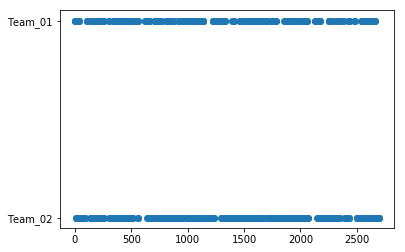

In [128]:
plt.scatter(test.time_sec, test.team_id)

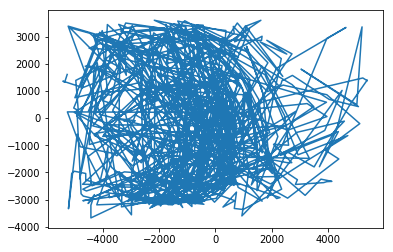

In [133]:
plt.plot(test.posx, test.posy)

### A cette étape, nous avons une BDD avec les positions du ballon mais avec quelques trous ...

Il convient donc de construire 

In [7]:
pos_ballon = test.sort_values(by=['time_sec'])
pos_ballon

time_sec ht  posx  posy      name_id  team_id   date_id   match_id
124       1.0  1   110   -95  Player_0044  Team_01  Date_001  Match_001
125       3.0  1 -2127 -1151  Player_0067  Team_01  Date_001  Match_001
126       5.0  1 -1649 -2437  Player_0021  Team_01  Date_001  Match_001
127       9.0  1  1916 -1701  Player_0063  Team_02  Date_001  Match_001
128      13.0  1  1699   877  Player_0036  Team_02  Date_001  Match_001
129      17.0  1  1106  2652  Player_0070  Team_02  Date_001  Match_001
130      21.0  1  2220  -680  Player_0063  Team_02  Date_001  Match_001
131      23.0  1  1484 -2673  Player_0035  Team_02  Date_001  Match_001
132      27.0  1  1486 -1112  Player_0063  Team_02  Date_001  Match_001
133      31.0  1  1172  1238  Player_0036  Team_02  Date_001  Match_001
134      33.0  1  -808  3305  Player_0029  Team_02  Date_001  Match_001
135      34.0  1 -1474  3103  Player_0090  Team_01  Date_001  Match_001
136      35.0  1 -1389  3347  Player_0090  Team_01  Date_001  Match_001
137      35.0  1 -1409  3252  Player_0029  Team_02  Date_001  Match_001
138      41.0  1 -1092  3589  Player_0070  Team_02  Date_001  Match_001
139      45.0  1   591  2649  Player_0036  Team_02  Date_001  Match_001
140      50.0  1  -391  -969  Player_0063  Team_02  Date_001  Match_001
141      52.0  1  -583 -2710  Player_0035  Team_02  Date_001  Match_001
142      54.0  1 -1558 -3148  Player_0004  Team_02  Date_001  Match_001
143      55.0  1  -397 -2788  Player_0035  Team_02  Date_001  Match_001
144      57.0  1  -620 -1824  Player_0030  Team_02  Date_001  Match_001
145      59.0  1   693 -1657  Player_0063  Team_02  Date_001  Match_001
146      63.0  1   398   678  Player_0036  Team_02  Date_001  Match_001
147      65.0  1 -1148   578  Player_0060  Team_02  Date_001  Match_001
148      66.0  1  -416  1375  Player_0088  Team_02  Date_001  Match_001
149      67.0  1   604   911  Player_0036  Team_02  Date_001  Match_001
150      71.0  1  -253  -633  Player_0030  Team_02  Date_001  Match_001
151      74.0  1  -870 -3114  Player_0035  Team_02  Date_001  Match_001
152      75.0  1 -1458 -3019  Player_0004  Team_02  Date_001  Match_001
153      77.0  1  -710 -3158  Player_0035  Team_02  Date_001  Match_001
..        ... ..   ...   ...          ...      ...       ...        ...
94     2604.0  1 -3195  3505  Player_0090  Team_01  Date_001  Match_001
95     2605.0  1 -1380  3232  Player_0044  Team_01  Date_001  Match_001
96     2606.0  1  -345  1740  Player_0087  Team_01  Date_001  Match_001
97     2609.0  1    86  1186  Player_0010  Team_01  Date_001  Match_001
98     2611.0  1   360  -414  Player_0092  Team_01  Date_001  Match_001
99     2616.0  1  2334  1257  Player_0070  Team_02  Date_001  Match_001
100    2616.0  1  2364  1374  Player_0044  Team_01  Date_001  Match_001
101    2617.0  1  2738  1575  Player_0044  Team_01  Date_001  Match_001
102    2619.0  1  4046   690  Player_0036  Team_02  Date_001  Match_001
103    2620.0  1  5088   425  Player_0034  Team_02  Date_001  Match_001
104    2621.0  1  3046  1805  Player_0044  Team_01  Date_001  Match_001
105    2621.0  1  5031   494  Player_0034  Team_02  Date_001  Match_001
106    2650.0  1  5216  3363  Player_0079  Team_01  Date_001  Match_001
107    2652.0  1  4336  -321  Player_0030  Team_02  Date_001  Match_001
108    2652.0  1  4333  -348  Player_0067  Team_01  Date_001  Match_001
109    2653.0  1  4293  -462  Player_0067  Team_01  Date_001  Match_001
111    2655.0  1  4373  -497  Player_0063  Team_02  Date_001  Match_001
110    2655.0  1  3698 -1791  Player_0092  Team_01  Date_001  Match_001
112    2658.0  1  2301 -1310  Player_0021  Team_01  Date_001  Match_001
113    2659.0  1  2315 -1373  Player_0021  Team_01  Date_001  Match_001
114    2659.0  1  4095  -640  Player_0063  Team_02  Date_001  Match_001
115    2672.0  1  4587  -111  Player_0034  Team_02  Date_001  Match_001
116    2674.0  1  2905  -522  Player_0030  Team_02  Date_001  Match_001
117    2676.0  1  1862 -1411  Player_0056  Te

In [8]:
def get_position_interpol(pos_ballon, time_sec_r):
    pos_ballon = test.sort_values(by=['time_sec'])
    x1 = pos_ballon[pos_ballon.time_sec <= time_sec_r].iloc[0].posx
    y1 = pos_ballon[pos_ballon.time_sec <= time_sec_r].iloc[0].posy
    t1 = pos_ballon[pos_ballon.time_sec <= time_sec_r].iloc[0].time_sec
    x2 = pos_ballon[pos_ballon.time_sec >= time_sec_r].iloc[0].posx
    y2 = pos_ballon[pos_ballon.time_sec >= time_sec_r].iloc[0].posy
    t2 = pos_ballon[pos_ballon.time_sec >= time_sec_r].iloc[0].time_sec
    
    if (t1 != t2):
        ya = (y2 - y1)/(t2 - t1) 
        yb = y1 - ya*t1
        yt = yb + ya*time_sec_r
        xa = (x2 - x1)/(t2 - t1) 
        xb = x1 - xa*t1
        xt = xb + xa*time_sec_r
        return xt,yt
    else :
        return x1,y1

In [146]:
get_position_interpol(pos_ballon, 2)

(-1008.5, -623.0)

Maintenant que nous avons une fonction nous donnant à tout instant la position du ballon. Construisons notre BDD de phase de possession. 

## BDD phases de possession

In [9]:
pos_ballon = test.sort_values(by=['time_sec'])
team = list(set(pos_ballon.team_id))[0]

poss_team1 = (pos_ballon.team_id == team).astype(np.float32).cumsum()
poss_team2 = (pos_ballon.team_id != team).astype(np.float32).cumsum()

pos_ballon['poss_id']=None
pos_ballon.loc[:,'poss_id'][pos_ballon.team_id == team] = poss_team2
pos_ballon.loc[:,'poss_id'][pos_ballon.team_id != team] = poss_team1

pos_ballon.poss_id = pos_ballon.apply(lambda df : df.team_id+"_"+str(int(df.poss_id)), axis = 1)
pos_ballon

# Pour avoir l'id, il faut croiser (Equipe, Poss_id)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


time_sec ht  posx  posy      name_id  team_id   date_id   match_id  \
124       1.0  1   110   -95  Player_0044  Team_01  Date_001  Match_001   
125       3.0  1 -2127 -1151  Player_0067  Team_01  Date_001  Match_001   
126       5.0  1 -1649 -2437  Player_0021  Team_01  Date_001  Match_001   
127       9.0  1  1916 -1701  Player_0063  Team_02  Date_001  Match_001   
128      13.0  1  1699   877  Player_0036  Team_02  Date_001  Match_001   
129      17.0  1  1106  2652  Player_0070  Team_02  Date_001  Match_001   
130      21.0  1  2220  -680  Player_0063  Team_02  Date_001  Match_001   
131      23.0  1  1484 -2673  Player_0035  Team_02  Date_001  Match_001   
132      27.0  1  1486 -1112  Player_0063  Team_02  Date_001  Match_001   
133      31.0  1  1172  1238  Player_0036  Team_02  Date_001  Match_001   
134      33.0  1  -808  3305  Player_0029  Team_02  Date_001  Match_001   
135      34.0  1 -1474  3103  Player_0090  Team_01  Date_001  Match_001   
136      35.0  1 -1389  3347  Player_0090  Team_01  Date_001  Match_001   
137      35.0  1 -1409  3252  Player_0029  Team_02  Date_001  Match_001   
138      41.0  1 -1092  3589  Player_0070  Team_02  Date_001  Match_001   
139      45.0  1   591  2649  Player_0036  Team_02  Date_001  Match_001   
140      50.0  1  -391  -969  Player_0063  Team_02  Date_001  Match_001   
141      52.0  1  -583 -2710  Player_0035  Team_02  Date_001  Match_001   
142      54.0  1 -1558 -3148  Player_0004  Team_02  Date_001  Match_001   
143      55.0  1  -397 -2788  Player_0035  Team_02  Date_001  Match_001   
144      57.0  1  -620 -1824  Player_0030  Team_02  Date_001  Match_001   
145      59.0  1   693 -1657  Player_0063  Team_02  Date_001  Match_001   
146      63.0  1   398   678  Player_0036  Team_02  Date_001  Match_001   
147      65.0  1 -1148   578  Player_0060  Team_02  Date_001  Match_001   
148      66.0  1  -416  1375  Player_0088  Team_02  Date_001  Match_001   
149      67.0  1   604   911  Player_0036  Team_02  Date_001  Match_001   
150      71.0  1  -253  -633  Player_0030  Team_02  Date_001  Match_001   
151      74.0  1  -870 -3114  Player_0035  Team_02  Date_001  Match_001   
152      75.0  1 -1458 -3019  Player_0004  Team_02  Date_001  Match_001   
153      77.0  1  -710 -3158  Player_0035  Team_02  Date_001  Match_001   
..        ... ..   ...   ...          ...      ...       ...        ...   
94     2604.0  1 -3195  3505  Player_0090  Team_01  Date_001  Match_001   
95     2605.0  1 -1380  3232  Player_0044  Team_01  Date_001  Match_001   
96     2606.0  1  -345  1740  Player_0087  Team_01  Date_001  Match_001   
97     2609.0  1    86  1186  Player_0010  Team_01  Date_001  Match_001   
98     2611.0  1   360  -414  Player_0092  Team_01  Date_001  Match_001   
99     2616.0  1  2334  1257  Player_0070  Team_02  Date_001  Match_001   
100    2616.0  1  2364  1374  Player_0044  Team_01  Date_001  Match_001   
101    2617.0  1  2738  1575  Player_0044  Team_01  Date_001  Match_001   
102    2619.0  1  4046   690  Player_0036  Team_02  Date_001  Match_001   
103    2620.0  1  5088   425  Player_0034  Team_02  Date_001  Match_001   
104    2621.0  1  3046  1805  Player_0044  Team_01  Date_001  Match_001   
105    2621.0  1  5031   494  Player_0034  Team_02  Date_001  Match_001   
106    2650.0  1  5216  3363  Player_0079  Team_01  Date_001  Match_001   
107    2652.0  1  4336  -321  Player_0030  Team_02  Date_001  Match_001   
108    2652.0  1  4333  -348  Player_0067  Team_01  Date_001  Match_001   
109    2653.0  1  4293  -462  Player_0067  Team_01  Date_001  Match_001   
111    2655.0  1  4373  -497  Player_0063  Team_02  Date_001  Match_001   
110    2655.0  1  3698 -1791  Player_0092  Team_01  Date_001  Match_001   
112    2658.0  1  2301 -1310  Player_0021  Team_01  Date_001  Match_001   
113    2659.0  1  2315 -1373  Player_0021  Team_01  Date_001  Match_001   
114    2659.0  1  4095  -640  Player_0063  Team_02  Date_001  Match_001   
115    2672.0  1  4587  -111  

In [77]:
poss_gby = pos_ballon.groupby('poss_id')
stat_poss = pd.DataFrame([],columns=[])
stat_poss['nb_pass']  = poss_gby.ht.count()
stat_poss['time_min_sec'] = poss_gby.time_sec.min()
stat_poss['time_max_sec'] = poss_gby.time_sec.max()
stat_poss['duree_sec'] = poss_gby.time_sec.max() - poss_gby.time_sec.min()
stat_poss['freq_pass_sec'] = (poss_gby.time_sec.max() - poss_gby.time_sec.min()) / poss_gby.ht.count()
diff_x = poss_gby.apply(lambda df: df.posx.diff().fillna(0.).apply(lambda x : (x*0.01)**2))
diff_y = poss_gby.apply(lambda df: df.posy.diff().fillna(0.).apply(lambda x : (x*0.01)**2))
diff_t = poss_gby.apply(lambda df: df.time_sec.diff().fillna(1.))
stat_poss['dist_m'] = (diff_x/diff_t + diff_y/diff_t).apply(lambda x : x**(0.5)).groupby('poss_id').sum()
stat_poss['vit_ms'] = stat_poss['dist_m']/stat_poss['duree_sec']
stat_poss.describe().transpose().round()

count    mean    std  min    25%     50%     75%     max
nb_pass        252.0     4.0    5.0  1.0    1.0     2.0     4.0    35.0
time_min_sec   252.0  1328.0  781.0  1.0  669.0  1406.0  1928.0  2659.0
time_max_sec   252.0  1336.0  781.0  5.0  692.0  1412.0  1938.0  2698.0
duree_sec      252.0     7.0   14.0  0.0    0.0     1.0     9.0    80.0
freq_pass_sec  252.0     1.0    2.0  0.0    0.0     0.0     2.0    22.0
dist_m         252.0    26.0   49.0  0.0    0.0     1.0    34.0   366.0
vit_ms         131.0     4.0    3.0  0.0    3.0     4.0     5.0    21.0

Filtrer pour retirer les arrêts de jeux (penalty, coup,franc)